In [1]:
#data analysis of spring dataset

flow_x dtype: float32, shape: (2160, 3840)
flow_y dtype: float32, shape: (2160, 3840)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Flow visualization saved as flow_visualization.png


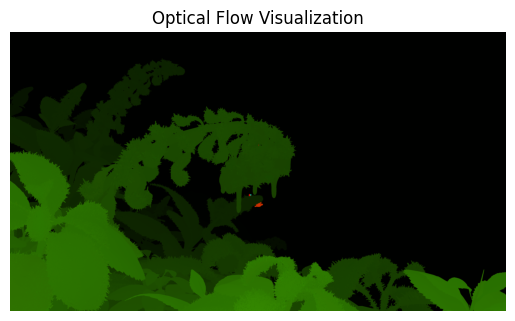

In [5]:
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Function to read and extract optical flow data from an HDF5 (.flo5) file
def read_flo5_file(file_path):
    with h5py.File(file_path, 'r') as f:
        # Assuming the dataset key inside the HDF5 file contains flow data
        flow_data = f['flow'][:]  # Change 'flow' to your actual dataset key
        
        # Flow data is expected to be [H, W, 2] where the last dimension contains u and v components
        return flow_data

# Function to convert optical flow to RGB using HSV color space
def flow_to_color(flow):
    """Convert optical flow to RGB image using HSV color model."""
    h, w = flow.shape[:2]
    hsv = np.zeros((h, w, 3), dtype=np.float32)
    
    # Get flow components (u and v)
    flow_x = flow[:, :, 0]
    flow_y = flow[:, :, 1]

    # Ensure the data types are float32 (CV_32F)
    flow_x = flow_x.astype(np.float32)
    flow_y = flow_y.astype(np.float32)

    # Print flow data types and shapes for debugging
    print(f"flow_x dtype: {flow_x.dtype}, shape: {flow_x.shape}")
    print(f"flow_y dtype: {flow_y.dtype}, shape: {flow_y.shape}")

    # Convert flow vectors to magnitude and angle
    magnitude, angle = cv2.cartToPolar(flow_x, flow_y)

    # Normalize magnitude to [0, 1]
    hsv[..., 0] = angle * 180 / np.pi / 2  # Hue represents the angle
    hsv[..., 1] = 1  # Full saturation
    hsv[..., 2] = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX)  # Value represents the magnitude

    # Convert HSV to RGB for visualization
    rgb_flow = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    
    return rgb_flow

# Function to process .flo5 file and visualize/save the optical flow as an image
def process_flo5_file(flo5_file, output_image):
    # Read the optical flow data from the .flo5 (HDF5) file
    flow = read_flo5_file(flo5_file)
    
    # Convert the optical flow to a color representation
    flow_rgb = flow_to_color(flow)
    
    # Save the flow visualization as an image
    cv2.imwrite(output_image, (flow_rgb * 255).astype(np.uint8))
    print(f"Flow visualization saved as {output_image}")
    
    # Display the flow visualization
    plt.imshow(flow_rgb)
    plt.title('Optical Flow Visualization')
    plt.axis('off')
    plt.show()


if __name__ == "__main__":
    # Path to your .flo5 (HDF5) file
    flo5_file = '/data/maryam.sana/datazips/spring/train/0008/flow_FW_left/flow_FW_left_0007.flo5'  # Replace with the actual path
    
    # Output image path
    output_image = 'flow_visualization.png'
    
    # Process and visualize the .flo5 file
    process_flo5_file(flo5_file, output_image)


In [19]:
from torch.utils.data import DataLoader
from src.train.video_dataset import *

# Define the dataset root directory and other parameters
root_dir = "/data/maryam.sana/datazips/spring/"
frame_dir = "frame_left"
optical_flow_dir = "flow_images"
encoded_frame_dir = "encoded_left"
resolution = 512  # Example resolution
global_type_list = []  # Populate with your global types as required
drop_txt_prob = 0.1  # Example probabilities
keep_all_cond_prob = 0.8
drop_all_cond_prob = 0.1
drop_each_cond_prob = [0.5,0.5]

# Initialize the custom dataset
dataset = UniVideoDataset(
    root=root_dir,
    frame_dir=frame_dir,
    optical_flow_dir=optical_flow_dir,
    encoded_frame_dir=encoded_frame_dir,
    global_type_list=global_type_list,
    resolution=resolution,
    drop_txt_prob=drop_txt_prob,
    keep_all_cond_prob=keep_all_cond_prob,
    drop_all_cond_prob=drop_all_cond_prob,
    drop_each_cond_prob=drop_each_cond_prob,
    split="train"
)

# Create a DataLoader to handle batching, shuffling, etc.
batch_size = 1  # Adjust as necessary for your system's memory
shuffle = True  # Enable shuffling for training

# Initialize the DataLoader
dataloader = DataLoader(
    dataset,
    num_workers=4,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    persistent_workers=True,
)


In [2]:
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from ldm.util import instantiate_from_config

config_path = 'configs/spring_op/local_v15.yaml'
batch_size = 4
num_workers = 4
gpus = -1

config = OmegaConf.load(config_path)
dataset = instantiate_from_config(config["data"])
dataloader = DataLoader(
    dataset,
    num_workers=num_workers,
    batch_size=batch_size,
    pin_memory=True,
    shuffle=True,
    persistent_workers=True,
)

for batch in dataloader:
    # `batch` is a list of dictionaries, each containing 'jpg', 'txt', 'local_conditions', and 'global_conditions'
    for sample in batch:
        # print(sample.keys())
        images = sample['jpg']  # Image data
        txt = sample['txt']  # Text/annotation data
        local_conditions = sample['local_conditions']  # Local conditions (optical flow and encoded frame)
        global_conditions = sample['global_conditions']  # Global conditions
        
        # Now you can use images, local_conditions, global_conditions in your model
        print("Images shape:", np.array(images).shape)
        print(txt)
        print("Local conditions shape:", np.array(local_conditions).shape)
        print("Global conditions shape:", np.array(global_conditions).shape)

ModuleNotFoundError: No module named 'omegaconf'